In [22]:
import numpy as np
import random
import cv2
def generate_dust_mask(
    image_shape=(1024, 1024),
    num_blobs=80,
    num_scratches=2,
    num_hairs=20,
    max_blob_size=2,
    max_scratch_length=240,
    max_hair_length=80,
    squiggliness=0.9,
    blur_kernel=(3, 3)
):
    """
    Returns a float32 dust mask with values from ~0.6 to 1.0 (not binary).
    Now with subtle parameter variations for better training diversity.
    """
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.float32)

    def rand_count(base):
        return random.randint(int(base * 0.8), int(base * 1.2))  # Subtle ±20% variation

    # Slightly vary counts
    num_blobs = rand_count(num_blobs)
    num_scratches = rand_count(num_scratches)
    num_hairs = rand_count(num_hairs)
    
    # Slightly vary blob sizes
    max_blob_size = max_blob_size + random.randint(-1, 2)  # ±1-2 pixels
    max_blob_size = max(1, max_blob_size)

    # Dust blobs (ellipses) with slight variations
    for _ in range(num_blobs):
        temp = np.zeros_like(mask)
        center = (random.randint(0, w), random.randint(0, h))
        
        # Slight size variations
        axes = (
            random.randint(max(1, max_blob_size-1), max_blob_size+1),
            random.randint(1, max(1, max_blob_size // 2) + 1)
        )
        angle = random.randint(0, 180)
        cv2.ellipse(temp, center, axes, angle, 0, 360, 1.0, -1)
        
        # Slight opacity variations
        opacity = random.uniform(0.55, 1.0)  # Narrower range around original 0.6-1.0
        mask += temp * opacity

    # Scratches with slight variations
    for _ in range(num_scratches):
        temp = np.zeros_like(mask)
        x1, y1 = random.randint(0, w), random.randint(0, h)
        angle = random.uniform(0, 2 * np.pi)
        
        # Slight length variations
        length = random.randint(int(max_scratch_length * 0.7), int(max_scratch_length * 1.3))
        x2 = int(x1 + length * np.cos(angle))
        y2 = int(y1 + length * np.sin(angle))
        thickness = 1  # Slight thickness variation
        cv2.line(temp, (x1, y1), (x2, y2), 1.0, thickness)
        
        # Slight opacity variations
        opacity = random.uniform(0.55, 1.0)
        mask += temp * opacity

    # Hairs with slight variations
    for _ in range(num_hairs):
        temp = np.zeros_like(mask)
        points = []
        x, y = random.randint(0, w), random.randint(0, h)
        
        # Slight length variations
        hair_length = random.randint(int(max_hair_length * 0.8), int(max_hair_length * 1.2))
        num_segments = max(3, hair_length // random.randint(8, 12))  # Slight segment variation
        
        # Slight squiggliness variations
        hair_squiggliness = squiggliness * random.uniform(0.8, 1.2)

        angle = random.uniform(0, 2 * np.pi)
        dx_base = np.cos(angle)
        dy_base = np.sin(angle)

        for _ in range(num_segments):
            segment_length = random.uniform(8, 12)  # Slight segment length variation
            dx = dx_base * segment_length + hair_squiggliness * random.uniform(-segment_length, segment_length)
            dy = dy_base * segment_length + hair_squiggliness * random.uniform(-segment_length, segment_length)
            x = int(np.clip(x + dx, 0, w - 1))
            y = int(np.clip(y + dy, 0, h - 1))
            points.append((x, y))

        thickness = random.randint(1, 2)  # Slight thickness variation
        for i in range(len(points) - 1):
            cv2.line(temp, points[i], points[i + 1], 1.0, thickness)

        # Slight opacity variations
        opacity = random.uniform(0.55, 1.0)
        mask += temp * opacity

    # Slight blur variations
    blur_size = random.choice([blur_kernel[0], blur_kernel[0]+2])  # Original or slightly larger
    if blur_size > 1:
        mask = cv2.GaussianBlur(mask, (blur_size, blur_size), 0)

    # Normalize mask to [0, 1]
    mask = np.clip(mask, 0.0, 1.0)

    return mask

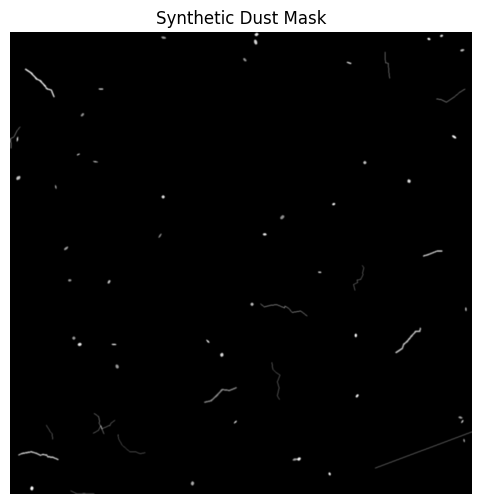

In [8]:
import matplotlib.pyplot as plt

mask = generate_dust_mask(image_shape=(1024, 1024))

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray', interpolation='bilinear')
plt.title("Synthetic Dust Mask")
plt.axis('off')
plt.show()

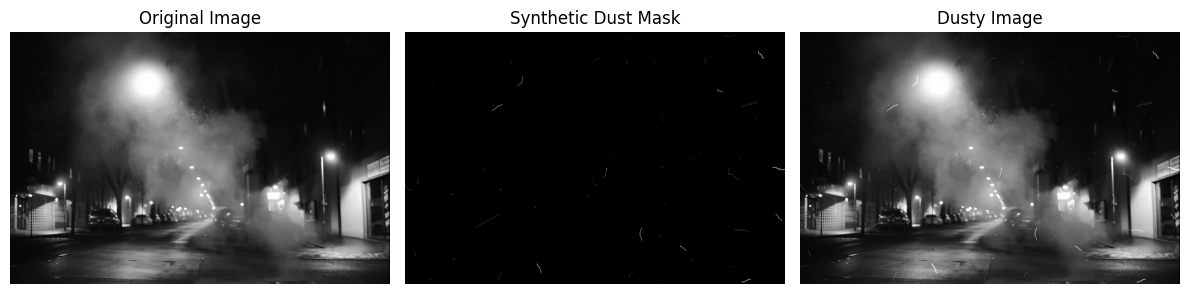

In [9]:
def apply_dust_to_greyscale_image(image_grey, mask, intensity=255):
    mask_float = mask.astype(np.float32)  # Already in [0.0, 1.0]
    image_float = image_grey.astype(np.float32)
    image_float += mask_float * intensity
    return np.clip(image_float, 0, 255).astype(np.uint8)

# ---- Load Image ----
img_path = "film-dataset/1216x806x2 (8)-topaz-denoise.jpeg"
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Could not read {img_path}")

# Convert to greyscale
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image_grey.shape

# ---- Generate Mask & Apply ----
mask = generate_dust_mask(image_shape=(h, w), squiggliness=0.7)
dusty_image = apply_dust_to_greyscale_image(image_grey, mask, intensity=255)

# ---- Visualize ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_grey, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Synthetic Dust Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dusty_image, cmap='gray')
plt.title("Dusty Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [228]:
plt.imsave("dusty_image.png", dusty_image, cmap='gray')

In [172]:
!pip install torch torchvision albumentations matplotlib scikit-image opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albucore]thon-headless]


In [10]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
from torchvision import transforms

class DustDataset(Dataset):
    def __init__(self, root_dir, image_size=(1024, 1024), transform=None):  # Increased to 1024x1024
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        clean_img = cv2.imread(path)
        
        # Convert to greyscale
        if len(clean_img.shape) == 3:
            clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2GRAY)
        
        # Resize image to 1024x1024
        clean_img = cv2.resize(clean_img, self.image_size)

        # generate synthetic dust mask with enhanced randomness
        mask = generate_dust_mask(image_shape=self.image_size, squiggliness=random.uniform(0.5, 1.5))

        # apply dust to the clean image using the mask with variable intensity
        dust_intensity = random.randint(150, 255)  # More variation in dust intensity
        dusty_img = apply_dust_to_greyscale_image(clean_img, mask, intensity=dust_intensity)

        # Normalize and prepare inputs - convert greyscale to single channel format
        image = dusty_img.astype(np.float32) / 255.0
        image = image[..., np.newaxis]  # Add channel dimension: HW -> HW1
        mask = mask.astype(np.float32)[..., np.newaxis]  # HW -> HW1, already in [0, 1] range

        # Apply augmentation (optional)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # CHW format
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        return image, mask

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Augmentations for greyscale images (removing RGB-only transforms)
transform = A.Compose([
    # Geometric transforms - films can be scanned at slight angles
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=5, p=0.4),  # Small rotations for scanning variations
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=3, p=0.3)
])

/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
            )

        # Back to 1 channel for greyscale
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)           # 512
        e2 = self.enc2(self.pool(e1))  # 256
        e3 = self.enc3(self.pool(e2))  # 128
        e4 = self.enc4(self.pool(e3))  # 64

        m = self.middle(self.pool(e4))  # 32

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))  # 64
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1)) # 128
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1)) # 256
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1)) # 512

        return torch.sigmoid(self.final(d1))  # 1x512x512

In [13]:
import torch
import torch.nn as nn

def dice_bce_loss(pred, target, smooth=1e-5):
    """Combined Dice and BCE loss for better segmentation performance"""
    bce = nn.BCELoss()(pred, target)
    
    # Flatten tensors for dice calculation
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    dice = (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    
    return bce + (1 - dice)

In [14]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
dataset = DustDataset("film-dataset", image_size=(1024, 1024), transform=transform)  # 1024x1024
loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Reduced batch size for 1024x1024

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)  # Lower learning rate for larger images
criterion = nn.BCELoss()

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

os.makedirs("checkpoints", exist_ok=True)
model.load_state_dict(torch.load('checkpoints/unet_epoch34.pth'))
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    # Save weights for each epoch
    torch.save(model.state_dict(), f"checkpoints/bce_unet_epoch{epoch+1:02d}.pth")

    # Step scheduler
    scheduler.step(avg_loss)

/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 315/315 [16:00<00:00,  3.05s/it]


Epoch 1: Loss = 0.0065


100%|██████████| 315/315 [15:20<00:00,  2.92s/it]


Epoch 2: Loss = 0.0060


100%|██████████| 315/315 [15:52<00:00,  3.02s/it]


Epoch 3: Loss = 0.0059


100%|██████████| 315/315 [15:21<00:00,  2.93s/it]


Epoch 4: Loss = 0.0059


100%|██████████| 315/315 [15:51<00:00,  3.02s/it]


Epoch 5: Loss = 0.0058


 26%|██▋       | 83/315 [04:07<11:31,  2.98s/it]


KeyboardInterrupt: 

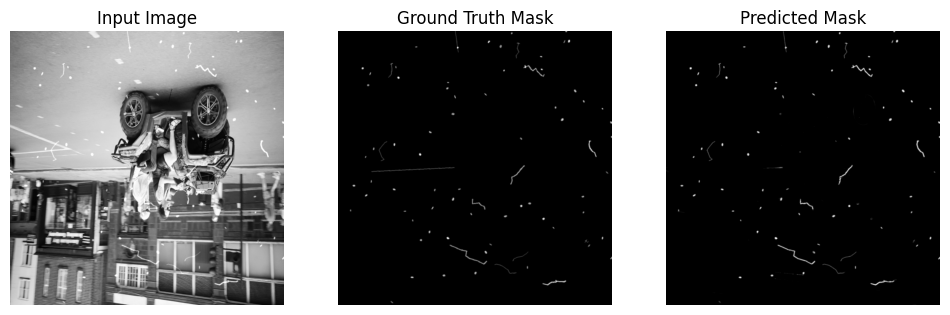

In [23]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(loader))
    preds = model(images.to(device)).cpu()

# Plot side-by-side for sanity check

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [223]:
plt.imsave("predicted_mask.png", np.transpose(preds[0].numpy(), (1, 2, 0)).squeeze(), cmap='gray')

In [ ]:
plt.imsave("input_image.png", images[0].squeeze(), cmap='gray')